In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from pathlib import Path

from pandas import testing as tm

import catboost as cb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance

from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

import shap

import math

import os
import src

from dotenv import load_dotenv

C:\Users\markelov.GIDROMETALL\Miniconda3\envs\ac\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
pd.options.display.float_format = '{:,.2f}'.format

In [4]:
load_dotenv(override=True)

WORK_DIR = os.getenv("DATA_DIR")
FILE_NAME = 'df_work_test.zip'

In [5]:
filepath = f'..\\{WORK_DIR}\\{FILE_NAME}'

df = pd.read_csv(filepath, index_col=0, parse_dates=True)

In [7]:
def add_lags_inplace(df: pd.DataFrame, num_lags: int) -> None:

    for lag in range(1, num_lags + 1):
        lag_name = f'lag_{lag}'
        df[lag_name] = df['Fe2+'].shift(lag)

    df.dropna(axis=0, inplace=True)

In [8]:
add_lags_inplace(df, 3)

In [10]:
X_train = df1.drop(['Fe2+'], axis=1)
y_train = df1['Fe2+']

X_2 = df2.drop(['Fe2+'], axis=1)
y_2 = df2['Fe2+']

X_3 = df3.drop(['Fe2+'], axis=1)
y_3 = df3['Fe2+']

X_test = df4.drop(['Fe2+'], axis=1)
y_test = df4['Fe2+']

In [11]:
train_data_1 = cb.Pool(X_1, y_1)
test_data = cb.Pool(X_test, y_test)

model_1 = cb.CatBoostRegressor(loss_function='RMSE', train_dir='..\\cache')
model_1.fit(train_data_1)

Learning rate set to 0.06021
0:	learn: 0.7292178	total: 163ms	remaining: 2m 43s
1:	learn: 0.7136587	total: 171ms	remaining: 1m 25s
2:	learn: 0.6990912	total: 179ms	remaining: 59.3s
3:	learn: 0.6862549	total: 187ms	remaining: 46.5s
4:	learn: 0.6739625	total: 195ms	remaining: 38.8s
5:	learn: 0.6619759	total: 202ms	remaining: 33.5s
6:	learn: 0.6509361	total: 210ms	remaining: 29.8s
7:	learn: 0.6414373	total: 218ms	remaining: 27.1s
8:	learn: 0.6322419	total: 227ms	remaining: 25s
9:	learn: 0.6246487	total: 238ms	remaining: 23.6s
10:	learn: 0.6165545	total: 250ms	remaining: 22.5s
11:	learn: 0.6092941	total: 261ms	remaining: 21.5s
12:	learn: 0.6022051	total: 270ms	remaining: 20.5s
13:	learn: 0.5960878	total: 279ms	remaining: 19.6s
14:	learn: 0.5904610	total: 289ms	remaining: 19s
15:	learn: 0.5847593	total: 301ms	remaining: 18.5s
16:	learn: 0.5798927	total: 310ms	remaining: 17.9s
17:	learn: 0.5754674	total: 320ms	remaining: 17.5s
18:	learn: 0.5709097	total: 331ms	remaining: 17.1s
19:	learn: 0.5

Метрики качества
RMSE: 0.8278
MAE: 0.3557
R2: 0.1592


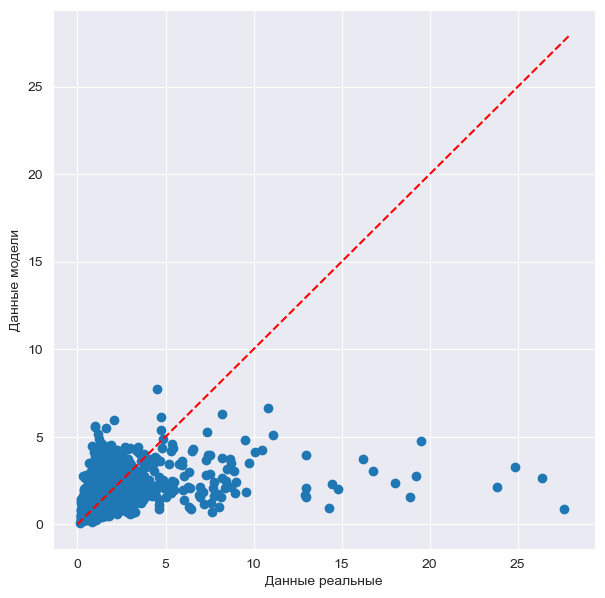

In [12]:
src.lib.model_score(model_1, X_test, y_test)

Метрики качества
RMSE: 0.1889
MAE: 0.1181
R2: 0.9358


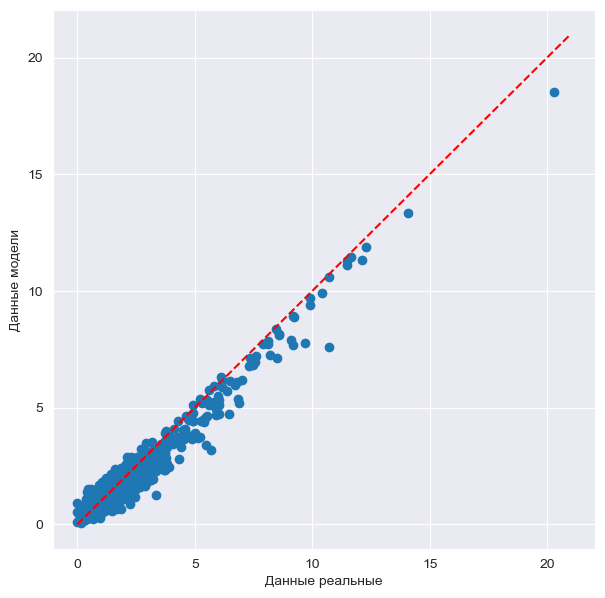

In [13]:
src.lib.model_score(model_1, X_1, y_1)

In [14]:
pred_cb_1 = model_1.predict(X_test)
pred_cb_2 = model_2.predict(X_test)
pred_cb_3 = model_3.predict(X_test)

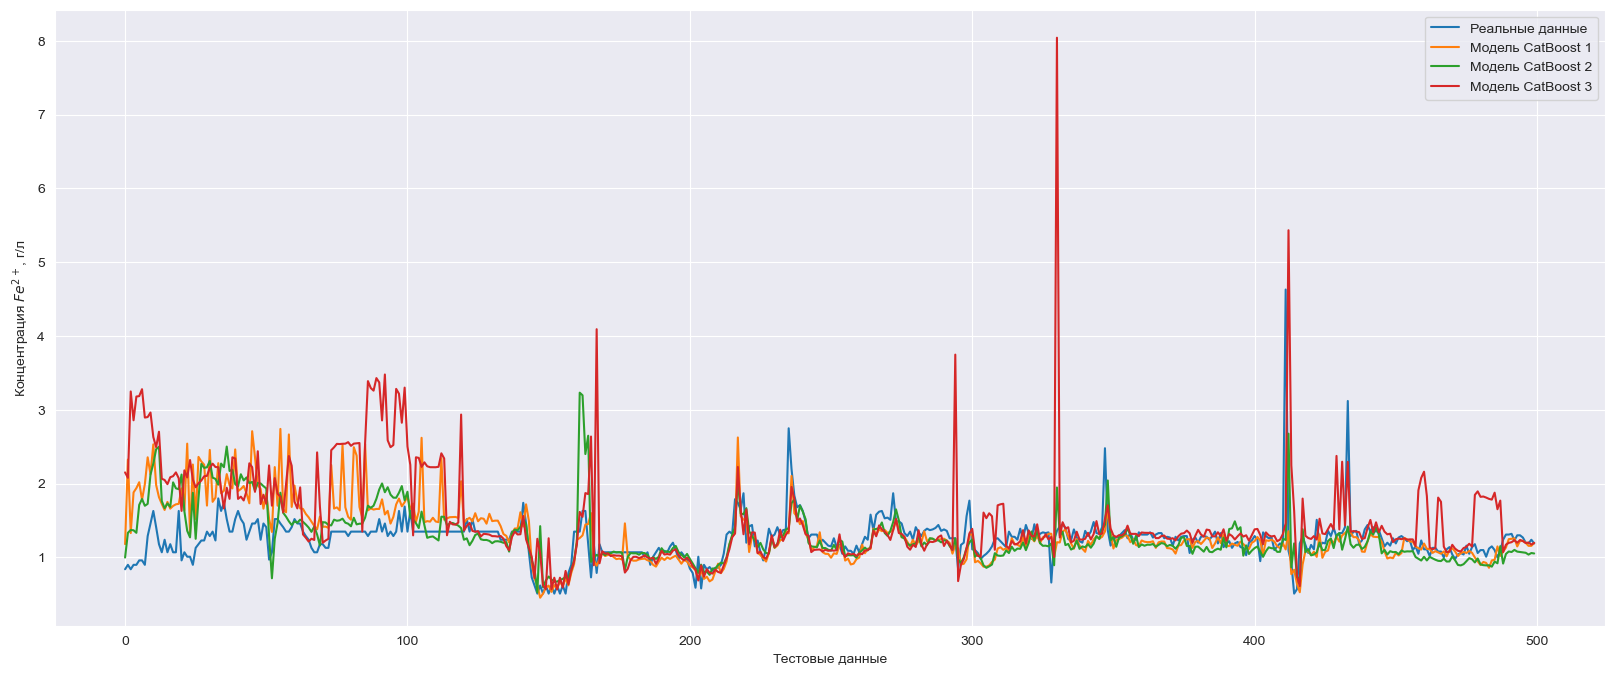

In [15]:
plt.figure(figsize=(20,8))

start = 0
end = 500

plt.plot(y_test.values[start:end], label='Реальные данные')
plt.plot(pred_cb_1[start:end], label='Модель CatBoost 1')
plt.plot(pred_cb_2[start:end], label='Модель CatBoost 2')
plt.plot(pred_cb_3[start:end], label='Модель CatBoost 3')
plt.ylabel("Концентрация $Fe^{2+}$, г/л")
plt.xlabel('Тестовые данные')

plt.legend()
plt.show();

In [16]:
final_pred = pred_cb_1 * 1/3 + pred_cb_2 * 1/3 + pred_cb_3 * 1/3

In [17]:
rmse = np.sqrt(mean_squared_error(y_test, final_pred))
r2 = r2_score(y_test, final_pred)
mae = mean_absolute_error(y_test, final_pred)

print("Метрики качества")
print("RMSE: {:.4f}".format(rmse))
print("MAE: {:.4f}".format(mae))
print("R2: {:.4f}".format(r2))

Метрики качества
RMSE: 0.8108
MAE: 0.3815
R2: 0.1935


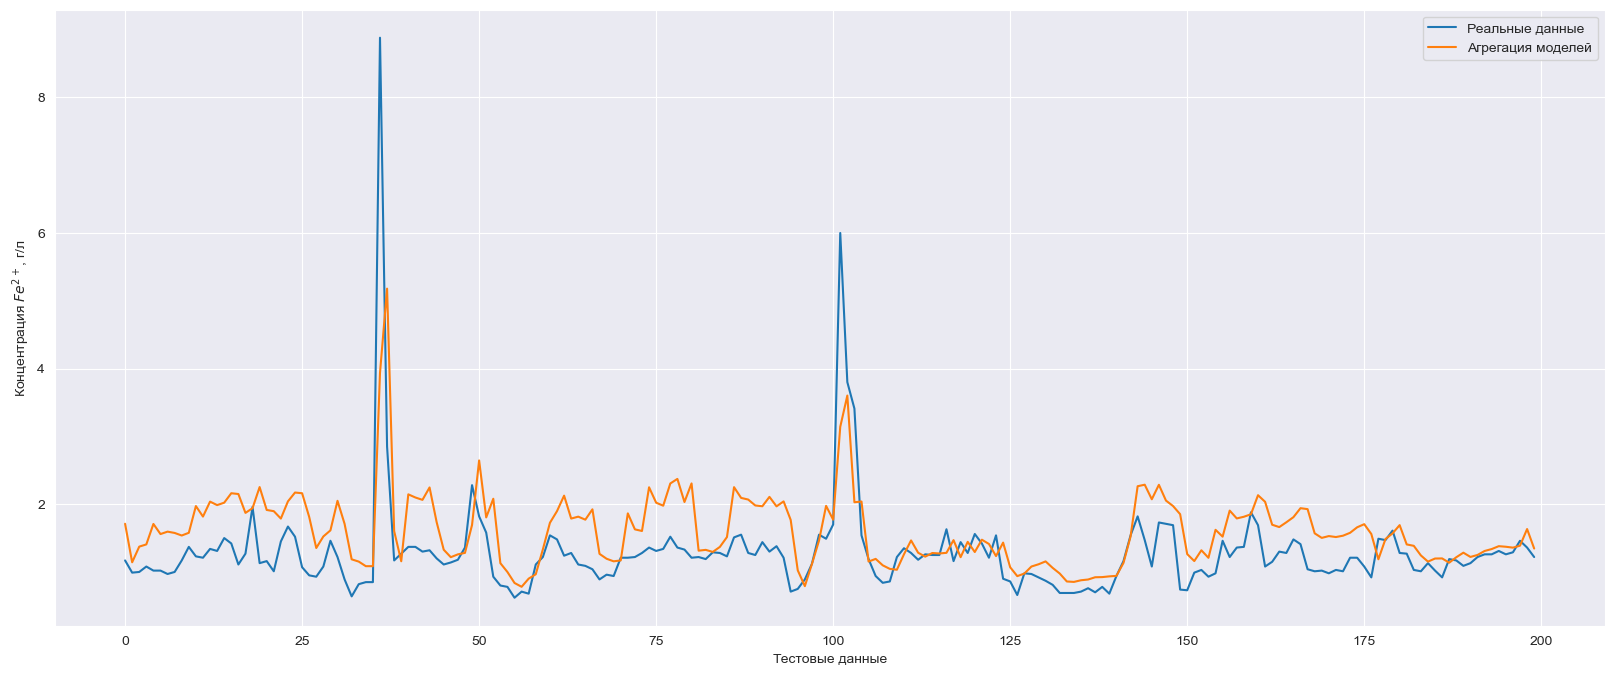

In [56]:
plt.figure(figsize=(20,8))

start = 1800
end = 2000

plt.plot(y_test.values[start:end], label='Реальные данные')
plt.plot(final_pred[start:end], label='Агрегация моделей')
plt.ylabel("Концентрация $Fe^{2+}$, г/л")
plt.xlabel('Тестовые данные')

plt.legend()
plt.show();

Попробуем объединить модели линейным классификатором

In [47]:
from sklearn.linear_model import Ridge

res_df = pd.DataFrame({1: pred_cb_1, 2: pred_cb_2, 3: pred_cb_3})
res_df = res_df.assign(y = y_test.values)

In [48]:
X_res_train, X_res_test, y_res_train, y_res_test = train_test_split(res_df.drop('y', axis=1), res_df['y'],test_size=0.2, shuffle=True, random_state=42)

In [49]:
reg = Ridge().fit(X_res_train, y_res_train)

In [50]:
reg_pred = reg.predict(X_res_test)

In [51]:
rmse = np.sqrt(mean_squared_error(y_res_test, reg_pred))
r2 = r2_score(y_res_test, reg_pred)
mae = mean_absolute_error(y_res_test, reg_pred)

print("Метрики качества")
print("RMSE: {:.4f}".format(rmse))
print("MAE: {:.4f}".format(mae))
print("R2: {:.4f}".format(r2))

Метрики качества
RMSE: 0.7384
MAE: 0.3059
R2: 0.2901


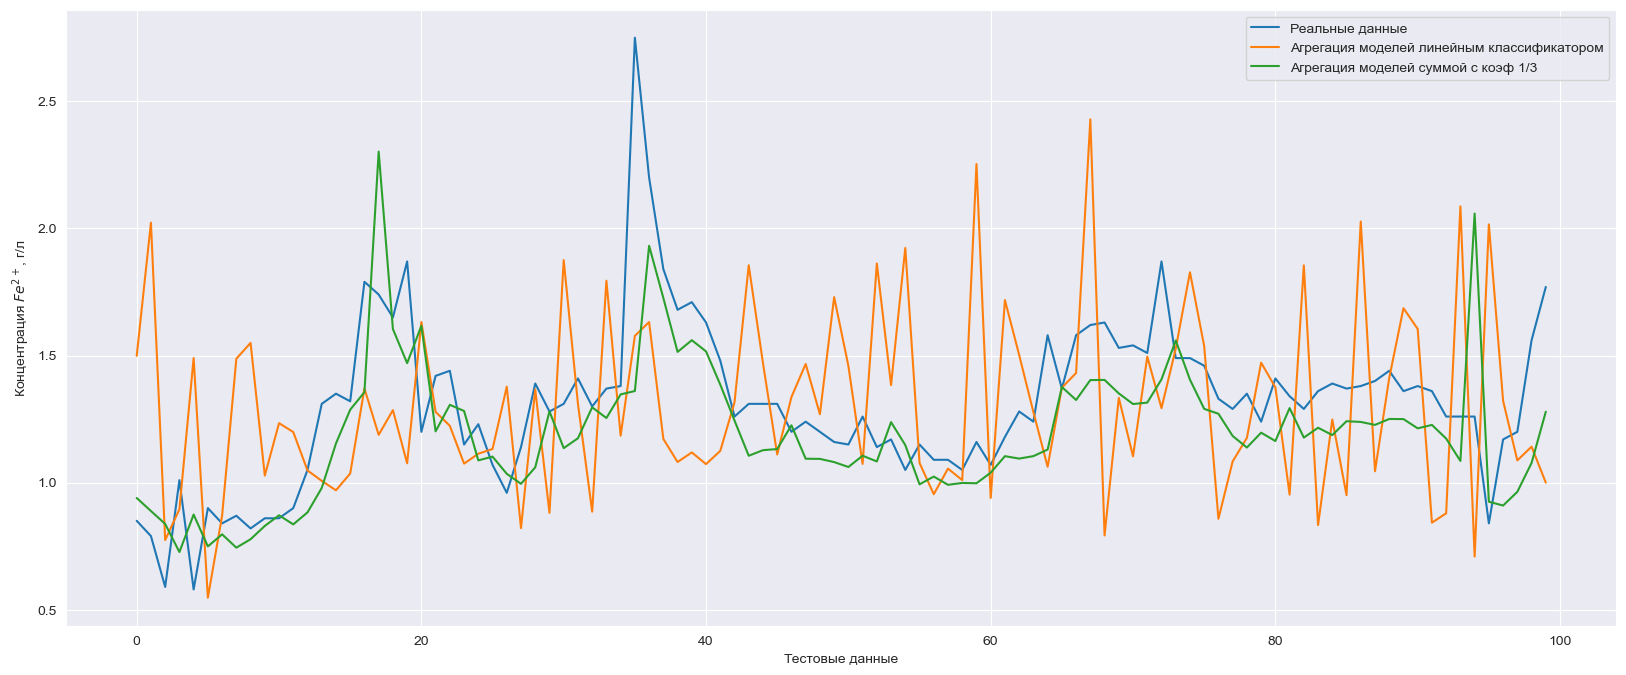

In [55]:
plt.figure(figsize=(20,8))

start = 200
end = 300

plt.plot(y_test.values[start:end], label='Реальные данные')
plt.plot(reg_pred[start:end], label='Агрегация моделей линейным классификатором')
plt.plot(final_pred[start:end], label='Агрегация моделей суммой с коэф 1/3')
plt.ylabel("Концентрация $Fe^{2+}$, г/л")
plt.xlabel('Тестовые данные')

plt.legend()
plt.show();

Видно, что метрики стали лучше, но модель стала давать больше колебаний, там где их реально нет. Пропала способность модели предсказывать пики. Таким образом можно сделать вывод, что линейный классификатор не сильно годится для объединения моделей.